**Распознавание рукописного ввода на примере базы MNIST**

Построить классификатор изображений рукописного ввода на базе MNIST. В качестве шаблона в данной работе можно использовать ipython-ноутбук 002-digit.ipynb.


Классификатор предлагается строить на признаках, полученных в результате предобработки изображений, например, гистограммы градиентов (HOG) или результат PCA преобразования.


В качестве модели классификатора можно использовать любую известную Вам модель, за исключением сверточных нейронных сетей.


Критерием качества классификатора является метрика accuracy. Для получения зачета по данной работе, значение метрики accuracy должно быть больше 0.6. Метрика оценивается на тестовой выборке в рамках контеста Digit Recognizer на Kaggle.


Решение необходимо предоставить в виде ipython-ноутбука с реализацией процесса построения модели и скриншота с финальным результатом на Kaggle.

In [ ]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train = np.loadtxt('train.csv', delimiter=',', skiprows=1)
test = np.loadtxt('test.csv', delimiter=',', skiprows=1)

In [ ]:
# сохраняем разметку в отдельную переменную
train_label = train[:, 0]

# приводим размерность к удобному для обаботки виду
train_img = np.resize(train[:, 1:], (train.shape[0], 28, 28))
test_img = np.resize(test, (test.shape[0], 28, 28))

## Визуализируем исходные данные

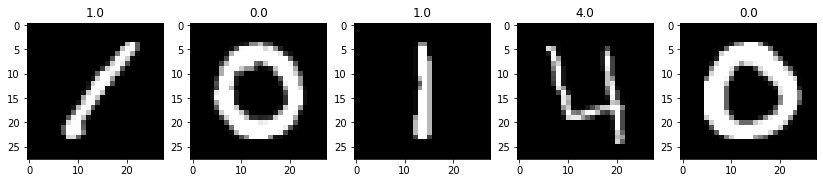

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);

## Вычисляем X и Y составляющие градиента с помощью оператора Собеля

In [ ]:
train_sobel_x = np.zeros_like(train_img)
train_sobel_y = np.zeros_like(train_img)
for i in range(len(train_img)):
    train_sobel_x[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    train_sobel_y[i] = cv2.Sobel(train_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

In [ ]:
test_sobel_x = np.zeros_like(test_img)
test_sobel_y = np.zeros_like(test_img)
for i in range(len(test_img)):
    test_sobel_x[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=1, dy=0, ksize=3)
    test_sobel_y[i] = cv2.Sobel(test_img[i], cv2.CV_64F, dx=0, dy=1, ksize=3)

## Вычисляем угол и длину вектора градиента

In [ ]:
train_g, train_theta = cv2.cartToPolar(train_sobel_x, train_sobel_y)

In [ ]:
test_g, test_theta = cv2.cartToPolar(test_sobel_x, test_sobel_y)

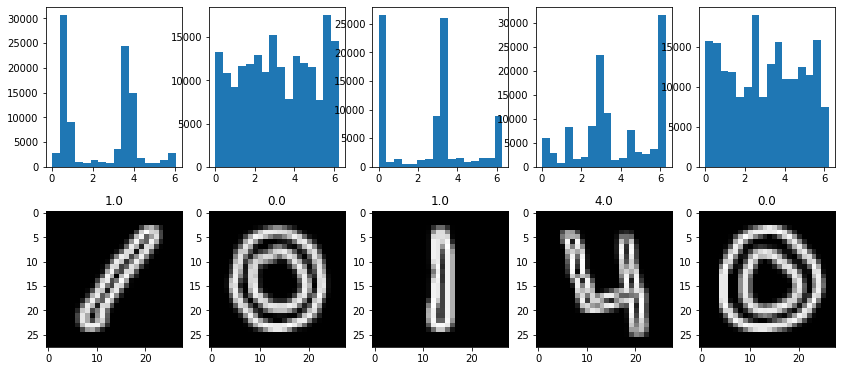

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(train_g[:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % train_label[i - 1]);
    subplot = fig.add_subplot(3, 7, i)
    plt.hist(train_theta[i - 1].flatten(),
             bins=16, weights=train_g[i - 1].flatten())

## Вычисляем гистограммы градиентов

In [ ]:
# Гистограммы вычисляются с учетом длины вектора градиента
train_hist = np.zeros((len(train_img), 16))
for i in range(len(train_img)):
    hist, borders = np.histogram(train_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=train_g[i])
    train_hist[i] = hist

In [ ]:
test_hist = np.zeros((len(test_img), 16))
for i in range(len(test_img)):
    hist, borders = np.histogram(test_theta[i],
                                 bins=16,
                                 range=(0., 2. * np.pi),
                                 weights=test_g[i])
    test_hist[i] = hist

## Разбиваем выборку на обучение и валидацию

In [ ]:
from sklearn.model_selection import train_test_split
y_train, y_val, x_train, x_val = train_test_split(
    train_label, train_hist, test_size=0.2, random_state=42)

## Метод логистической регрессии 

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [ ]:
model = LogisticRegression()

model = make_pipeline(StandardScaler(), 
                      LogisticRegression(max_iter=1000))

model.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [ ]:
y_pred = model.predict(x_val)

In [ ]:
from sklearn.metrics import accuracy_score
print('Accuracy: %s' % accuracy_score(y_val, y_pred))

Accuracy: 0.6320238095238095


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

         0.0       0.65      0.70      0.68       816
         1.0       0.91      0.97      0.94       909
         2.0       0.42      0.34      0.38       846
         3.0       0.63      0.69      0.66       937
         4.0       0.63      0.64      0.63       839
         5.0       0.60      0.67      0.63       702
         6.0       0.45      0.39      0.42       785
         7.0       0.77      0.77      0.77       893
         8.0       0.54      0.54      0.54       835
         9.0       0.57      0.55      0.56       838

    accuracy                           0.63      8400
   macro avg       0.62      0.63      0.62      8400
weighted avg       0.62      0.63      0.63      8400



In [ ]:
y_pred.shape

(8400,)

In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, y_pred))

[[572   0  43  10  53  14  30   0  90   4]
 [  0 886   3   0   7   0   2   5   3   3]
 [ 31   4 286 165  11 147  47  32  91  32]
 [  1   0 125 645   1  97   7   7  21  33]
 [ 31  31   5   4 541   1  96  27  26  77]
 [  1   1  80 108   0 470   8  13  17   4]
 [112  14  54  10 105   8 308  33  75  66]
 [  0   9  28  11  22  21  41 692  11  58]
 [105   3  32  35  34  22  76   8 452  68]
 [ 21  21  20  28  91   3  67  76  54 457]]


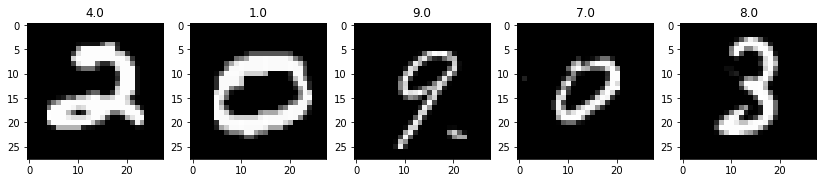

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % y_pred[i - 1]);

## SVM

In [ ]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto')) 
clf.fit(x_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto'))])

In [ ]:
predict = clf.predict(x_val)

In [ ]:
print('Accuracy: %s' % accuracy_score(y_val, predict))

Accuracy: 0.7217857142857143


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_val, predict))

              precision    recall  f1-score   support

         0.0       0.73      0.76      0.75       816
         1.0       0.97      0.97      0.97       909
         2.0       0.53      0.47      0.50       846
         3.0       0.71      0.77      0.74       937
         4.0       0.78      0.71      0.75       839
         5.0       0.66      0.72      0.69       702
         6.0       0.55      0.54      0.55       785
         7.0       0.87      0.83      0.85       893
         8.0       0.65      0.70      0.67       835
         9.0       0.72      0.71      0.71       838

    accuracy                           0.72      8400
   macro avg       0.72      0.72      0.72      8400
weighted avg       0.72      0.72      0.72      8400



In [ ]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_val, predict))

[[618   1  48  13  11  13  37   1  66   8]
 [  0 883   1   0   7   0   3   5   0  10]
 [ 34   0 399 121   4 123  60  14  76  15]
 [  1   0  93 723   3  77   5   2  28   5]
 [ 22  16  11   0 599   2  80  26  10  73]
 [  0   0  61 106   1 504   6   9  14   1]
 [ 89   1  53  10  62   6 426  11  85  42]
 [  0   6  27   6  30  14  21 737   7  45]
 [ 64   1  34  30   8  27  57   3 581  30]
 [ 14   7  26  13  41   2  75  36  31 593]]


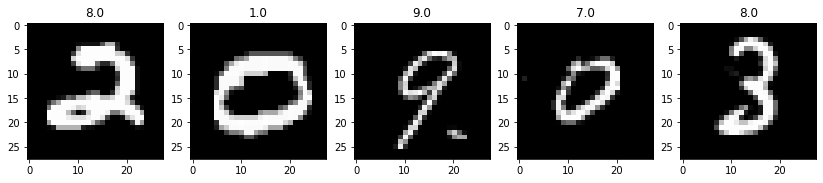

In [ ]:
fig = plt.figure(figsize=(20, 10))
for i, img in enumerate(test_img[0:5], 1):
    subplot = fig.add_subplot(1, 7, i)
    plt.imshow(img, cmap='gray');
    subplot.set_title('%s' % predict[i - 1]);

### Готовим файл для отправки

In [ ]:
with open('submit.txt', 'w') as dst:
    dst.write('ImageId,Label\n')
    for i, p in enumerate(predict, 1):
        dst.write('%s,%d\n' % (i, p))